In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import holidays
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna


In [45]:

pathtodf = "train.csv"
df = pd.read_csv(pathtodf)

# Convert to datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Drop the 'store' column it is not needed
df.drop('store', axis=1, inplace=True)


# Group by 'item' and 'date', then sum sales
df = df.groupby(['date','item'])['sales'].sum().reset_index()
print(df.shape)
df.head()

(91300, 3)


,date,item,sales
0,2013-01-01,1,133
1,2013-01-01,2,327
2,2013-01-01,3,172
3,2013-01-01,4,102
4,2013-01-01,5,83


In [46]:
import numpy as np
#this functiuon reduces the outliers effect on calculations and predictions
df['sales'] = np.log1p(df['sales'])  # Apply log(1 + x) transformation


# feature engineering part

In [47]:
us_holidays = holidays.US(years=range(2012, 2026))

def create_features(df):
    """
    Create time series features based on time series index.
    """
    
    # Holiday-based features
    df["is_holiday"] = df["date"].isin(us_holidays).astype(float)
    df["is_pre_holiday"] = df["date"].isin([d - timedelta(days=1) for d in us_holidays]).astype(float)
    df["is_post_holiday"] = df["date"].isin([d + timedelta(days=1) for d in us_holidays]).astype(float)

    # Time features
    df['dayofweek'] = df["date"].dt.dayofweek
    df['quarter'] = df["date"].dt.quarter
    df['month'] = df["date"].dt.month
    df['year'] = df["date"].dt.year
    df['dayofyear'] = df["date"].dt.dayofyear
    df['dayofmonth'] = df["date"].dt.day
    df['weekofyear'] = df["date"].dt.isocalendar().week

   
    df['fourier_sin_365'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['fourier_cos_365'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    df['rolling_mean_7'] = df.groupby('item')['sales'].shift(1).transform(lambda x: x.rolling(7, min_periods=1).mean())
    df['rolling_mean_30'] = df.groupby('item')['sales'].shift(1).transform(lambda x: x.rolling(30, min_periods=1).mean())
    df['rolling_std_7'] = df.groupby('item')['sales'].shift(1).transform(lambda x: x.rolling(7, min_periods=1).std())
    df['rolling_std_30'] = df.groupby('item')['sales'].shift(1).transform(lambda x: x.rolling(30, min_periods=1).std())
    df['rolling_min_7'] = df.groupby('item')['sales'].transform(lambda x: x.shift(1).rolling(7).min())
    df['rolling_max_7'] = df.groupby('item')['sales'].transform(lambda x: x.shift(1).rolling(7).max())
    df['rolling_median_7'] = df.groupby('item')['sales'].transform(lambda x: x.shift(1).rolling(7).median())
    df['rolling_skew_7'] = df.groupby('item')['sales'].transform(lambda x: x.shift(1).rolling(7).skew())
    df['rolling_kurt_7'] = df.groupby('item')['sales'].transform(lambda x: x.shift(1).rolling(7).kurt())
    df['pct_change_1'] = (
        df.groupby('item')['sales']
        .transform(lambda x: x.pct_change(periods=1).shift(1))
    )

    df['pct_change_7'] = (
        df.groupby('item')['sales']
        .transform(lambda x: x.pct_change(periods=7).shift(1))
    )

    df['autocorr_7'] = (df.groupby('item')['sales'].transform(lambda x: x.shift(1).rolling(14).apply(lambda y: y.autocorr(lag=7), raw=False)))
    for lag in [1, 7]:
        df[f'lag_{lag}'] = df.groupby('item')['sales'].shift(lag)

    # Exponentially Weighted Moving Average (EWMA) with a span of 3 days
    df['ewm_3'] = (
    df.groupby('item')['sales']
    .transform(lambda x: x.shift(1).ewm(span=3, adjust=False).mean())
)


    return df

# Apply to your data
df = create_features(df)
df.dropna(inplace=True)
df.head()


C:\Users\user\AppData\Local\Temp\ipykernel_10208\2476235032.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df["date"].isin(us_holidays).astype(float)
C:\Users\user\AppData\Local\Temp\ipykernel_10208\2476235032.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_pre_holiday"] = df["date"].isin([d - timedelta(days=1) for d in us_holidays]).astype(float)
C:\Users\user\AppData\Local\Temp\ipykernel_10208\2476235032.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future versi

,date,item,sales,is_holiday,is_pre_holiday,is_post_holiday,dayofweek,quarter,month,year,...,rolling_max_7,rolling_median_7,rolling_skew_7,rolling_kurt_7,pct_change_1,pct_change_7,autocorr_7,lag_1,lag_7,ewm_3
700,2013-01-15,1,4.804021,0.0,0.0,0.0,1,1,1,2013,...,5.141664,4.787492,0.474109,0.369384,-0.118457,0.000000,0.761196,4.532599,4.787492,4.759934
701,2013-01-15,2,5.780744,0.0,0.0,0.0,1,1,1,2013,...,5.986452,5.817111,-0.574584,-0.237585,-0.075955,-0.001428,0.941787,5.529429,5.743003,5.737680
702,2013-01-15,3,5.370638,0.0,0.0,0.0,1,1,1,2013,...,5.533389,5.313206,0.325163,-2.082172,-0.061523,-0.006275,0.805361,5.192957,5.204007,5.336501
703,2013-01-15,4,4.691348,0.0,0.0,0.0,1,1,1,2013,...,4.948760,4.795791,-0.180062,-0.314855,-0.053878,0.014520,0.727447,4.682131,4.624973,4.785149
704,2013-01-15,5,4.624973,0.0,0.0,0.0,1,1,1,2013,...,4.787492,4.634729,1.162398,2.195191,-0.051007,0.062345,0.913846,4.543295,4.553877,4.626403


# split dataset

In [48]:
# --- 0. Prepare your df (assume df already has all engineered features) ---
df = df.sort_values("date").reset_index(drop=True) #this means that we sort and reset the index and drop the old index

# Reserve the last 10% as a pure test set
n = len(df)
test_size = int(0.1 * n)
trainval = df.iloc[:-test_size]
test     = df.iloc[-test_size:]

feature_cols = [c for c in df.columns if c not in ("sales", "date")]
X_trainval = trainval[feature_cols]
y_trainval = trainval["sales"]

X_test = test[feature_cols]
y_test = test["sales"]

In [49]:
n = len(trainval)
train = trainval[:int(n*0.9)]
valid = trainval[int(n*0.9):]

X_train, y_train = train[feature_cols], train["sales"]
X_valid, y_valid = valid[feature_cols], valid["sales"]



# train the model

In [50]:

def objective(trial):
    # 6.1 Suggest hyperparameters
    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        "booster": "gbtree",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha":  trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "subsample":        trial.suggest_float("subsample", 0.3, 1.0),
        "learning_rate":    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth":        trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "n_estimators":     trial.suggest_int("n_estimators", 50, 500),
    }

    # 6.2 Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, missing=np.nan)

    # 6.3 Train with early stopping
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=params["n_estimators"],
        evals=[(dvalid, "valid")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # 6.4 Predict & compute RMSE on validation
    preds = bst.predict(dvalid)
    
    rmse = np.sqrt(mean_squared_error(y_valid, preds))

    return rmse

# 7. Run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # try 50 trials; increase as needed

# 8. Output best parameters
print("Best RMSE:", study.best_value)
print("Best params:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

# 9. Train final model on full df
best_params = study.best_trial.params.copy()
best_params.update({
    "objective": "reg:squarederror",
    "verbosity": 0
})
n_estimators = best_params.pop("n_estimators")
dall = xgb.DMatrix(X_trainval, label=y_trainval, missing=np.nan)
final_model = xgb.train(
    best_params,
    dall,
    num_boost_round=n_estimators
)


[I 2025-06-11 11:07:56,404] A new study created in memory with name: no-name-0cb4ee6e-9a19-4819-9045-df42cb6c5675
C:\Users\user\AppData\Local\Temp\ipykernel_10208\568881555.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_10208\568881555.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha":  trial.suggest_loguniform("alpha", 1e-8, 1.0),
[I 2025-06-11 11:07:58,062] Trial 0 finished with value: 0.05357029494155933 and parameters: {'lambda': 1.7732776730335186e-06, 'alpha': 0.002023347354572901, 'colsample_bytree': 0.5818415136560727, 'subsample': 0.744372544065096

Best RMSE: 0.052014768442415045
Best params:
  lambda: 0.00012246990309115762
  alpha: 3.491467758495675e-05
  colsample_bytree: 0.8055763386226992
  subsample: 0.48988841164345653
  learning_rate: 0.022353522226534805
  max_depth: 9
  min_child_weight: 9
  n_estimators: 419


# evaluate

In [51]:
def recursive_forecast(model, start_df, horizon,item):
    
    forecast_df = start_df[start_df['item'] == item].copy()


    for i in range(horizon):
   

        
        next_date = forecast_df['date'].max() + pd.Timedelta(days=1)
    
        
        new_row = {'date': next_date, 'item': item, 'sales': np.nan}
        forecast_df = pd.concat([forecast_df, pd.DataFrame([new_row])], ignore_index=True)

       
        forecast_df = create_features(forecast_df)

        next_df = forecast_df[forecast_df['date'] == next_date]
        
        # Predict the next day's sales
        dnext = xgb.DMatrix(next_df[feature_cols], missing=np.nan)
        next_sales = model.predict(dnext)[0]
        
        # Append the prediction to the forecast DataFrame
        forecast_df.loc[forecast_df["date"] == next_date, "sales"] = next_sales
    
    return forecast_df


181


C:\Users\user\AppData\Local\Temp\ipykernel_10208\2476235032.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df["date"].isin(us_holidays).astype(float)
C:\Users\user\AppData\Local\Temp\ipykernel_10208\2476235032.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_pre_holiday"] = df["date"].isin([d - timedelta(days=1) for d in us_holidays]).astype(float)
C:\Users\user\AppData\Local\Temp\ipykernel_10208\2476235032.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future versi

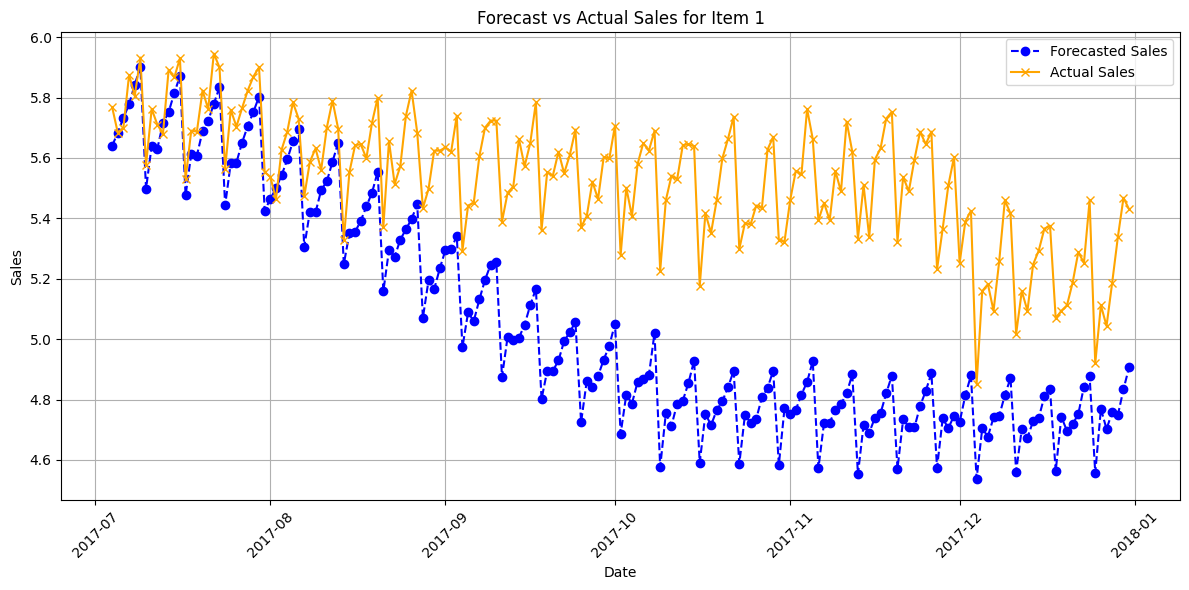

In [52]:
start_date = test['date'].min()
end_date = test['date'].max()

horizon = (end_date - start_date).days
print(horizon)
forecast_df = recursive_forecast(final_model,start_df= trainval,  horizon = horizon ,item=1)

# Determine forecast range: last `horizon` rows
forecast_only = forecast_df.tail(horizon)
test = test[test['item'] == 1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(forecast_only['date'], forecast_only['sales'], label='Forecasted Sales', color='blue', linestyle='--', marker='o')
plt.plot(test['date'], test['sales'], label='Actual Sales', color='orange', marker='x')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"Forecast vs Actual Sales for Item {1}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

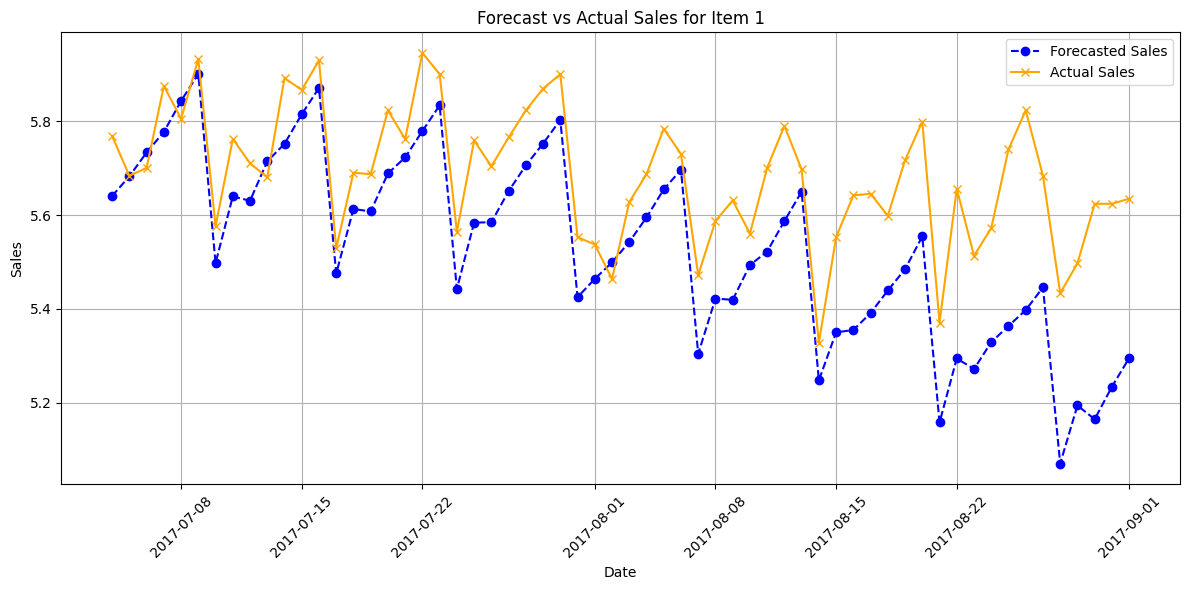

In [53]:
# Determine forecast range: last `horizon` rows
forecast_only = forecast_only.head(60)
test = test.head(60)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(forecast_only['date'], forecast_only['sales'], label='Forecasted Sales', color='blue', linestyle='--', marker='o')
plt.plot(test['date'], test['sales'], label='Actual Sales', color='orange', marker='x')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"Forecast vs Actual Sales for Item {1}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()